In [104]:
%matplotlib inline
# import some useful modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.api as sm
import os.path
import urllib
import altair as alt
import folium
import json
import pyproj
import numpy
from matplotlib import pyplot

In [105]:
# load the data from https://www.dft.gov.uk/traffic-counts/cp.php?la=City+of+Edinburgh
DATA_URL = 'http://api.dft.gov.uk/v3/trafficcounts/export/la/City+of+Edinburgh.csv'
dname = os.path.basename(DATA_URL)
if not os.path.exists(dname):
    urllib.urlretrieve(DATA_URL,dname)

In [106]:
# load the data into a pandas frame
aadf = pd.read_csv('City+of+Edinburgh.csv')

In [107]:
ngridCRS = {'init': 'epsg:27700'}
latlonCRS = {'init': 'epsg:4326'}
def addGeometry(data):
    geometry = [Point(xy) for xy in zip(data.Easting, data.Northing)]
    gdata = data.drop(['Easting','Northing'],axis=1)
    gdata = gpd.GeoDataFrame(gdata, crs=ngridCRS, geometry=geometry)
    gdata=gdata.to_crs(latlonCRS)
    return gdata

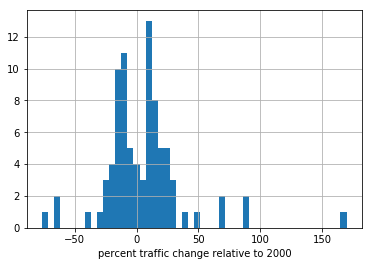

In [108]:
pos = addGeometry(aadf[['CP','Easting','Northing']].drop_duplicates(subset='CP'))
pos['change']=0

for r in pos.iterrows():
    #print (r[1]['CP'],end=" ")
    d = aadf[aadf.CP == r[1]['CP']][['AADFYear','AllMotorVehicles']]
    change = 100*(d.iloc[-1].AllMotorVehicles-d.iloc[0].AllMotorVehicles)/d.iloc[0].AllMotorVehicles
    pos.loc[pos.CP == r[1]['CP'],'change'] = change 
ax = pos.change.hist(bins=50)
ax.set_xlabel('percent traffic change relative to 2000' )
ax

Text(0,0.5,'percentage change since 2000')

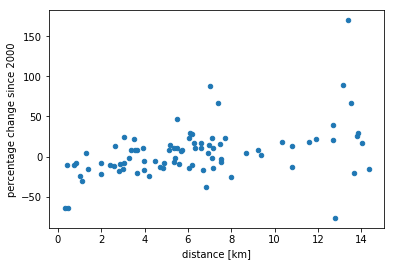

In [109]:
pos = pos.to_crs(ngridCRS)
castle = Point(-3.1999135,55.9485947)
castle = Point(pyproj.transform(pyproj.Proj(**latlonCRS),pyproj.Proj(**ngridCRS),-3.1999135,55.9485947))
pos['distance'] = pos.distance(castle)/1000
pos['change_type'] = numpy.where(pos['change']<0,'decrease','increase')
ax = pos[['distance','change']].plot.scatter(x='distance',y='change',)
ax.set_xlabel('distance [km]')
ax.set_ylabel('percentage change since 2000')

In [110]:
t=pos.geometry.translate(-castle.x,-castle.y)
pos['angle'] = numpy.arctan2(t.y,t.x)

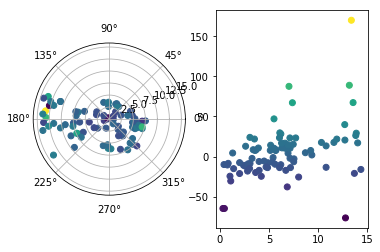

In [121]:
theta = numpy.array(pos.angle)
r = numpy.array(pos['distance'])
ax1 = pyplot.subplot(121, projection='polar')
ax1.scatter(theta,r,c=pos.change)
ax2 = pyplot.subplot(122)
ax2.scatter(pos['distance'],pos.change,c=pos.change)